# Time Series Analysis

In this notebook, we move from handling time to understanding patterns over time.

Our goals here are to:
- Analyze how nutrition-related variables change over time
- Understand trend, seasonality, and noise
- Learn how smoothing helps reveal patterns
- Perform basic statistical checks relevant to time series

Okay, an important thing is that, this notebook is about **what is happening**, not **what will happen**. No Forecasting yet.


## Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

### Why these libraries?

- Pandas for time-based aggregation
- Matplotlib for pattern visualization
- StatsModels for classical time series analysis tools


## Load the Dataset

In [2]:
df = pd.read_csv("nutrition_data.csv")
df.head()

,Date,Meal,Food_Item,Calories,Protein_g,Carbs_g,Fat_g,Meal_Time,Water_ml
0,2022-01-11,Breakfast,Pancakes,349.0,15.0,67.3,NaN,08:00,2036.0
1,2022-01-11,Lunch,Chicken,271.0,10.2,NaN,22.2,13:00,NaN
2,2022-01-11,Supper,Nuts,613.0,28.0,63.5,NaN,17:00,378.0
3,2022-01-11,Dinner,Fish,514.0,10.6,40.0,14.5,20:30,133.0
4,2022-01-12,Breakfast,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Convert and Prepare the date column Quickly.

In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")
df.head()

,Meal,Food_Item,Calories,Protein_g,Carbs_g,Fat_g,Meal_Time,Water_ml
Date,,,,,,,,
2022-01-11,Breakfast,Pancakes,349.0,15.0,67.3,NaN,08:00,2036.0
2022-01-11,Lunch,Chicken,271.0,10.2,NaN,22.2,13:00,NaN
2022-01-11,Supper,Nuts,613.0,28.0,63.5,NaN,17:00,378.0
2022-01-11,Dinner,Fish,514.0,10.6,40.0,14.5,20:30,133.0
2022-01-12,Breakfast,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating a Daily-Level Time Series

For time series analysis, we usually work with one value per time step.

#### Let's start with daily calorie intake.

In [4]:
daily_calories = df["Calories"].resample("D").sum()
daily_calories.head()

Date
2022-01-11    1747.0
2022-01-12    1452.0
2022-01-13    1210.0
2022-01-14    2053.0
2022-01-15    1066.0
Freq: D, Name: Calories, dtype: float64

### Visualizing the Raw Daily Series

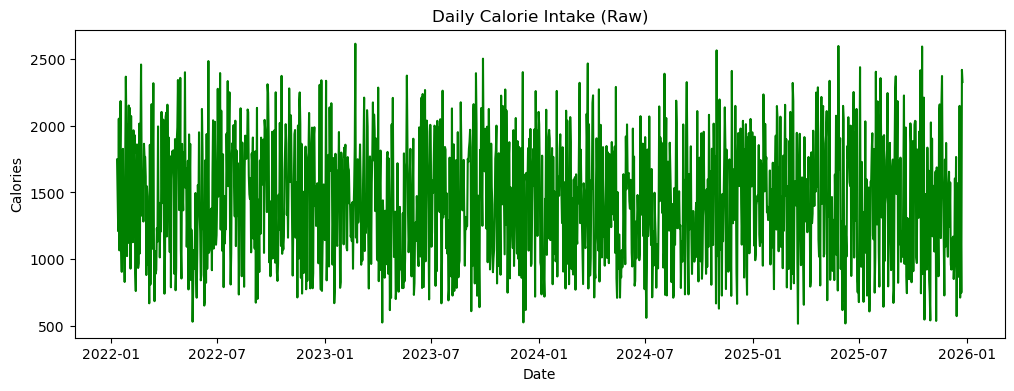

In [5]:
plt.figure(figsize=(12, 4))
plt.plot(daily_calories, c="g")
plt.title("Daily Calorie Intake (Raw)")
plt.xlabel("Date")
plt.ylabel("Calories")
plt.show()

#### What do we notice?
- High variability
- Spikes and drops
- Hard to see clear patterns

This is normal for real-world time series. So, don't worry about the noise.😅


## Smoothing with Moving Averages

To reduce noise, we use moving averages.

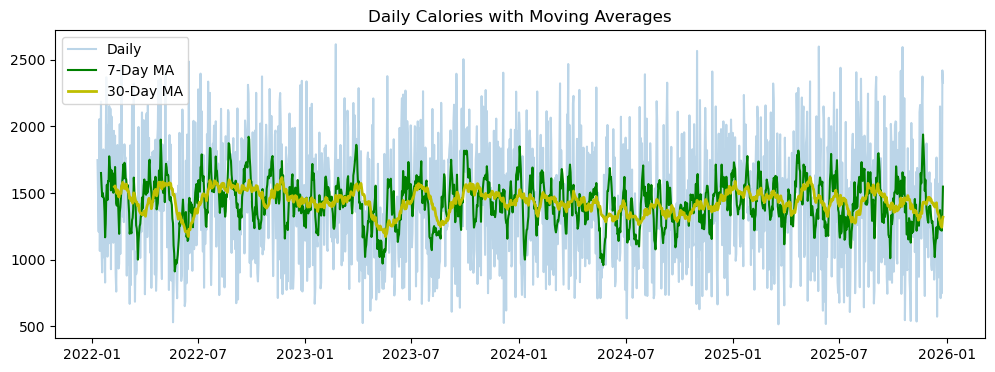

In [6]:
ma_7 = daily_calories.rolling(window=7).mean()
ma_30 = daily_calories.rolling(window=30).mean()

plt.figure(figsize=(12, 4))
plt.plot(daily_calories, alpha=0.3, label="Daily")
plt.plot(ma_7, c="g", label="7-Day MA")
plt.plot(ma_30, c="y", lw=2, label="30-Day MA")
plt.legend()
plt.title("Daily Calories with Moving Averages")
plt.show()

We can clearly see:
- **7-day MA** captures short-term behavior.
- **30-day MA** reveals long-term trend.
- Noise becomes much easier to reason about.


## Exploring Seasonality (Monthly View)

Let's look at monthly average calories.

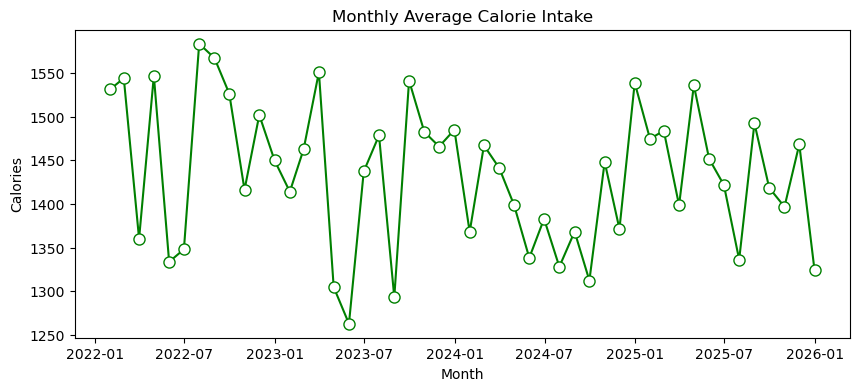

In [7]:
monthly_calories = daily_calories.resample("ME").mean()

plt.figure(figsize=(10, 4))
plt.plot(monthly_calories, "o-g", ms=8, mfc="w")
plt.title("Monthly Average Calorie Intake")
plt.xlabel("Month")
plt.ylabel("Calories")
plt.show()

#### Why this matters?

- Seasonality often appears at monthly or yearly levels
- Aggregation helps surface repeating patterns


## Time Series Decomposition

Now let's formally break the series into components:
- Trend
- Seasonality
- Residual (noise)

Before decomposition, we handle missing values.

In [8]:
daily_calories_filled = daily_calories.ffill()
daily_calories_filled.head()

Date
2022-01-11    1747.0
2022-01-12    1452.0
2022-01-13    1210.0
2022-01-14    2053.0
2022-01-15    1066.0
Freq: D, Name: Calories, dtype: float64

### Perform Decomposition Now

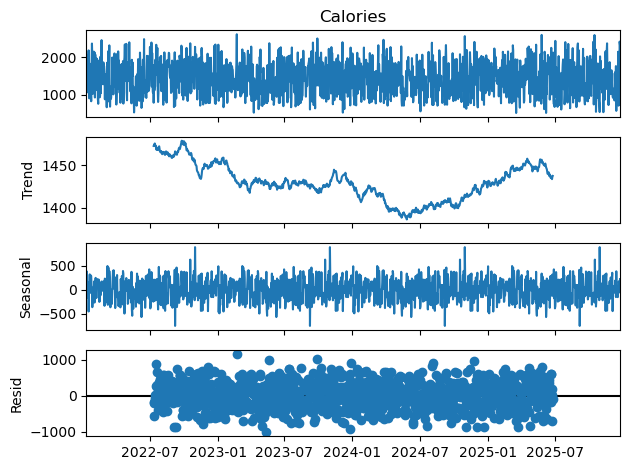

In [9]:
decomposition = seasonal_decompose(
    daily_calories_filled,
    model="additive",
    period=365,
)

decomposition.plot()
plt.show()


#### How to read this?

- **Trend:** long-term direction
- **Seasonal:** repeating yearly pattern
- **Residual:** random fluctuations

This is one of the most important visuals in time series analysis.


### Understanding Stationarity

A time series is stationary if:
- Mean is constant over time.
- Variance is constant.
- No changing trend or seasonality.

Most real-world time series (like ours) are not stationary.

Let's check this statistically.


### Augmented Dickey-Fuller (ADF) Test

In [10]:
adf_result = adfuller(daily_calories_filled.dropna())
adf_result

(np.float64(-37.61960979900456),
 0.0,
 0,
 1444,
 {'1%': np.float64(-3.434886677803751),
  '5%': np.float64(-2.8635436366589673),
  '10%': np.float64(-2.5678367211155533)},
 np.float64(21383.547305564334))

#### Let's make it a bit more readable.

In [11]:
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -37.61960979900456
p-value: 0.0


- `p-value < 0.05` means likely stationary
- `p-value ≥ 0.05` means non-stationary

Don't worry if it's non-stationary, cuz that's expected and totally fine at this stage.😅


## Variability Over Time

Let's see how weekly variability changes.

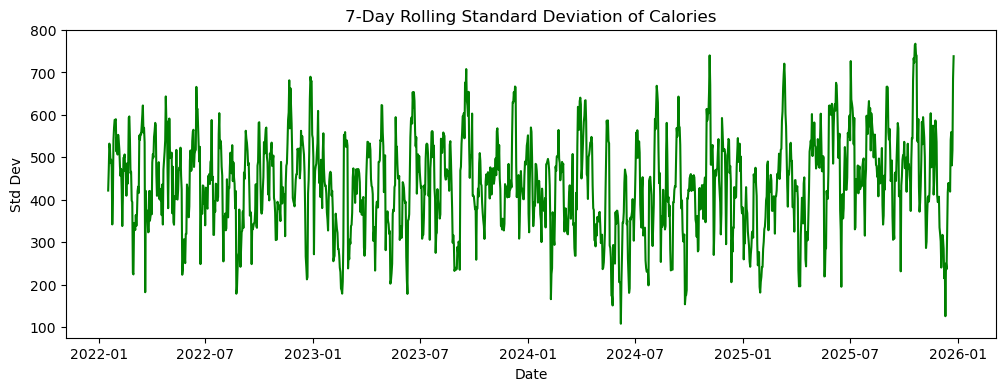

In [12]:
weekly_std = daily_calories.rolling(window=7).std()

plt.figure(figsize=(12, 4))
plt.plot(weekly_std, c="g")
plt.title("7-Day Rolling Standard Deviation of Calories")
plt.xlabel("Date")
plt.ylabel("Std Dev")
plt.show()

So, this plot is basically showing how consistent your daily calorie intake has been over time, using a 7‑day rolling standard deviation of calories.

#### What the metric means?

- Each point represents the standard deviation of your calories over the previous 7 days.
    - Higher values mean your intake that week was very erratic (big swings between high‑ and low‑calorie days).
    - Lower values mean your intake that week was more consistent (similar calories each day).

The visual is telling, the values mostly sit in a mid‑to‑high band (roughly 300–600), which implies frequent variation in daily calories rather than tight control around a fixed target. There are repeated spikes, indicating weeks where your pattern became especially irregular, followed by drops where things briefly stabilized again.


- Raw time series are usually noisy
- Moving averages help reveal structure
- Aggregation changes how patterns appear
- Decomposition separates trend, seasonality, and noise
- Most real-world time series are non-stationary
- Understanding behavior comes before forecasting

#### Since our Analysis is complete, now let's prepare data for visualization. We'll use this for Visual Storytelling later.

### Monthly overview aggregation

In [13]:
# Monthly overview aggregation
monthly_overview = df.resample("ME").agg({
    "Calories": ["sum", "mean"],
    "Protein_g": "mean",
    "Carbs_g": "mean",
    "Fat_g": "mean",
    "Water_ml": "mean"
})

# Flatten Column Names
monthly_overview.columns = [
    "Total_Calories",
    "Avg_Calories",
    "Avg_Protein_g",
    "Avg_Carbs_g",
    "Avg_Fat_g",
    "Avg_Water_ml"
]

# Reset Index
monthly_overview = monthly_overview.reset_index()
monthly_overview.rename(columns={"Date": "Month"}, inplace=True)

monthly_overview.to_csv("nutrition_updated.csv", index=False)

### Monthly Meal-Level Dataset

In [14]:
monthly_meal_summary = df.groupby([
    pd.Grouper(freq="ME"),
    "Meal"
]).agg({
    "Calories": "mean",
    "Protein_g": "mean",
    "Carbs_g": "mean",
    "Fat_g": "mean",
    "Water_ml": "mean"
})

# Reset Index
monthly_meal_summary = monthly_meal_summary.reset_index()
monthly_meal_summary.rename(columns={"Date": "Month"}, inplace=True)

# Rename Columns for Clarity
monthly_meal_summary.columns = [
    "Month",
    "Meal",
    "Avg_Calories",
    "Avg_Protein_g",
    "Avg_Carbs_g",
    "Avg_Fat_g",
    "Avg_Water_ml"
]

monthly_meal_summary.to_csv("meal_summary.csv", index=False)

----------